# Kolmogorov Complexity to Compress DNA Sequences Using Python
Long form blogpost can be found over here: [yacinemahdid.com](yacinemahdid.com)

The data used can be found over here: [Kaggle/Humans.txt file](https://www.kaggle.com/nageshsingh/dna-sequence-dataset/version/1?select=human.txt)

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt

# Sample dataset coming from Kaggle: https://www.kaggle.com/nageshsingh/dna-sequence-dataset
HOME = "C:/Users/Yacin/Desktop"
HUMAN_DNA_DATASET = f"{HOME}/human.txt"
df = pd.read_csv(HUMAN_DNA_DATASET, sep = "\t", names = ['sequence','class'], skiprows=1)

# No idea what the class variable is though as it wasn't mentioned in the dataset on Kaggle.
df

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3
...,...,...
4375,ATGGAAGATTTGGAGGAAACATTATTTGAAGAATTTGAAAACTATT...,0
4376,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6
4377,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6
4378,ATGGGGCACCTGGTTTGCTGTCTGTGTGGCAAGTGGGCCAGTTACC...,6


In [26]:
# Source is right here: https://github.com/Naereen/Lempel-Ziv_Complexity/blob/master/src/lempel_ziv_complexity.py

def lempel_ziv_complexity(binary_sequence):
    r""" Manual implementation of the Lempel-Ziv complexity.
    It is defined as the number of different substrings encountered as the stream is viewed from begining to the end.
    As an example:
    >>> s = '1001111011000010'
    >>> lempel_ziv_complexity(s)  # 1 / 0 / 01 / 11 / 10 / 110 / 00 / 010
    8
    Marking in the different substrings the sequence complexity :math:`\mathrm{Lempel-Ziv}(s) = 8`: :math:`s = 1 / 0 / 01 / 11 / 10 / 110 / 00 / 010`.
    - See the page https://en.wikipedia.org/wiki/Lempel-Ziv_complexity for more details.
    Other examples:
    >>> lempel_ziv_complexity('1010101010101010')  # 1, 0, 10, 101, 01, 010, 1010
    7
    >>> lempel_ziv_complexity('1001111011000010000010')  # 1, 0, 01, 11, 10, 110, 00, 010, 000
    9
    >>> lempel_ziv_complexity('100111101100001000001010')  # 1, 0, 01, 11, 10, 110, 00, 010, 000, 0101
    10
    - Note: it is faster to give the sequence as a string of characters, like `'10001001'`, instead of a list or a numpy array.
    - Note: see this notebook for more details, comparison, benchmarks and experiments: https://Nbviewer.Jupyter.org/github/Naereen/Lempel-Ziv_Complexity/Short_study_of_the_Lempel-Ziv_complexity.ipynb
    - Note: there is also a Cython-powered version, for speedup, see :download:`lempel_ziv_complexity_cython.pyx`.
    """
    sub_strings = set()
    n = len(binary_sequence)

    ind = 0
    inc = 1
    while True:
        if ind + inc > len(binary_sequence):
            break
        sub_str = binary_sequence[ind : ind + inc]
        if sub_str in sub_strings:
            inc += 1
        else:
            sub_strings.add(sub_str)
            ind += inc
            inc = 1
    return len(sub_strings)


def shannon_entropy(dna_sequence):
    """Custom implementation of shannon entropy with a full non-binarized sequence
        Formula looks like this
        H(S) = −Σ P(Si) log2 (P(Si))
        P(Si) is a bit confusing but, it's the relative frequency of the current char i in the whole string 
        as we are iterating on each character in the string. 
    """
    
    # Hold the relative frequency per nucleotide for a given dna sequence
    relative_freq_nucleotide = {
        'A' : 0, 
        'T' : 0, 
        'G' : 0, 
        'C': 0,
        'N' : 0
    }
    
    # Formula looks like this
    # H(S) = −Σ P(Si) log2 (P(Si))
    # P(Si) is a bit confusing but, it's the relative frequency of the current char i in the whole string 
    # as we are iterating on each character in the string. 

    
    # step 1: calculate all the frequency for each characters
    for nucleotide in relative_freq_nucleotide:
        relative_freq_nucleotide[nucleotide] = dna_sequence.count(nucleotide) / len(dna_sequence)
    
    # step 2: iterate over each nucleotide and sum up the relative frequency
    entropy = 0
    for nucleotide_i in dna_sequence:
        rel_freq = relative_freq_nucleotide[nucleotide_i]
        entropy = entropy - (rel_freq * math.log(rel_freq, 2))
        
    return entropy

def shannon_entropy_corrected(dna_sequence):
    """Custom implementation of shannon entropy with a full non-binarized sequence
        Formula looks like this
        H(S) = −Σ P(Si) log2 (P(Si))
        P(Si) here is simply the relative frequency of character A,T,G,C or n in the string.
    """
    
    entropy = 0
    for nucleotide in {'A', 'T', 'G', 'C', 'N'}:
        rel_freq = dna_sequence.count(nucleotide) / len(dna_sequence)
        if rel_freq > 0:
            entropy = entropy - (rel_freq * math.log(rel_freq, 2))
        
    return entropy

def string_to_binary(string_sequence):
    """Simple converter from a string sequence to a binary sequence"""
    return ''.join(format(ord(x), 'b') for x in string_sequence)

def generate_window(sequence, window_size=250, jump_size=50):
    """ Generator of windowed sequence with specific jump size
    Parameters:
    sequence (str): a string representing the data
    window_size (int): the size of the window we want to return
    jump_size (int): how much we want to move the window after each yield
    
    Yield:
    windowed sequence of specific size
    
    """
    start = 0
    end = window_size
    
    while end < len(sequence):
        yield sequence[start:end]
        
        start = start + jump_size
        end = end + jump_size

def generate_lz_sequence(sequence):
    """helper function to generate a list of Lempel-Ziv complexity metric"""
    lz_sequence = []
    for window in generate_window(sequence):
        encoded_sequence = string_to_binary(window)
        lz = lempel_ziv_complexity(encoded_sequence)
        lz_sequence.append(lz)
    
    return lz_sequence

def generate_shannon_sequence(sequence, shannon_fn):
    """helper function to generate a list of Shannon Entropy metric"""
    se_sequence = []
    for window in generate_window(sequence):
        se = shannon_fn(window)
        se_sequence.append(se)
        
    return se_sequence

def normalize_lz_sequence(lz_sequence, window_size=250):
    """helper function to normalize a sequence of Lempel-Ziv complexity metric"""
    return [lz/window_size for lz in lz_sequence]

In [27]:
# Data preparation
sequence_list = df.loc[:, 'sequence'].tolist()
# simulating a big chromosome dna sequence (it's not actually I'm not too sure what this data represent tbh)
mega_dna_sequence = ''.join(sequence_list)
len(mega_dna_sequence)

5534562

In [28]:
# Generating Shannon Entropy like the paper
se_sequence = generate_shannon_sequence(mega_dna_sequence, lambda seq : shannon_entropy(seq))
len(se_sequence)

110687

In [29]:
# Generating Shannon Entropy corrected to match the litterature
se_sequence_cor = generate_shannon_sequence(mega_dna_sequence, lambda seq : shannon_entropy_corrected(seq))
len(se_sequence_cor)

110687

In [30]:
# Generating the lempel-ziv sequence with window of 250 nucleotide and jumps of 50 nucleotid
lz_sequence = generate_lz_sequence(mega_dna_sequence)
len(lz_sequence)

110687

In [31]:
# Normalizing the LZ complexity between 0 and 1
n_lz_sequence = normalize_lz_sequence(lz_sequence, 250)

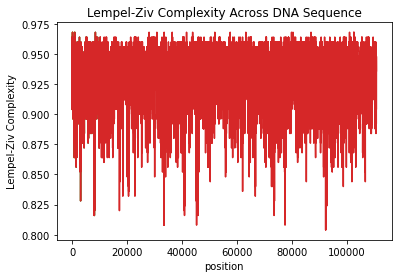

In [32]:
# Generating multiple Graphs at different resolution starting from the start of the DNA sequence for Lz Complexity
resolutions = [100, 1000, 10000]

for res in resolutions:
    plt.plot(n_lz_sequence[0:res])
    plt.xlabel("position")
    plt.ylabel("Lempel-Ziv Complexity")
    plt.title("Lempel-Ziv Complexity Across DNA Sequence")
    plt.savefig(f'{HOME}/lz_complexity_dna_{res}.png', dpi = 600)
    
plt.plot(n_lz_sequence)
plt.xlabel("position")
plt.ylabel("Lempel-Ziv Complexity")
plt.title("Lempel-Ziv Complexity Across DNA Sequence")
plt.savefig(f'{HOME}/lz_complexity_dna_full.png', dpi = 600)


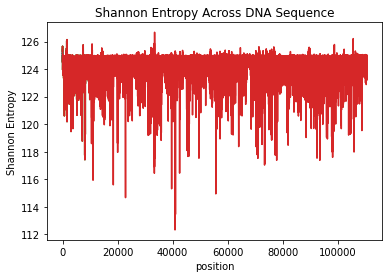

In [35]:
# Generating multiple Graphs at different resolution starting from the start of the DNA sequence for Shannon
resolutions = [100, 1000, 10000]

for res in resolutions:
    plt.plot(se_sequence[0:res])
    plt.xlabel("position")
    plt.ylabel("Shannon Entropy")
    #plt.ylim(100,150)
    plt.title("Shannon Entropy Across DNA Sequence")
    plt.savefig(f'{HOME}/se_dna_{res}.png', dpi = 600)
    
plt.plot(se_sequence)
plt.xlabel("position")
plt.ylabel("Shannon Entropy")
#plt.ylim(100,150)
plt.title("Shannon Entropy Across DNA Sequence")
plt.savefig(f'{HOME}/se_dna_full.png', dpi = 600)

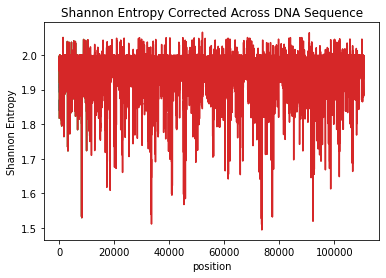

In [36]:
# Generating multiple Graphs at different resolution starting from the start of the DNA sequence for Shannon
resolutions = [100, 1000, 10000]

for res in resolutions:
    plt.plot(se_sequence_cor[0:res])
    plt.xlabel("position")
    plt.ylabel("Shannon Entropy")
    plt.title("Shannon Entropy Corrected Across DNA Sequence")
    plt.savefig(f'{HOME}/se_cor_dna_{res}.png', dpi = 600)
    
plt.plot(se_sequence_cor)
plt.xlabel("position")
plt.ylabel("Shannon Entropy")
plt.title("Shannon Entropy Corrected Across DNA Sequence")
plt.savefig(f'{HOME}/se_cor_dna_full.png', dpi = 600)